# **Install Required Libraries**

In [1]:
!pip install ultralytics torch torchvision matplotlib pillow opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.3/886.3 kB 19.4 MB/s eta 0:00:00


# **Clone and setup SAM2 repo**

In [2]:
!pip install iopath

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=f6f0d06f4d11465dea51290a3b6d49daa0a1940921821e70e2281df4088d6dcb
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built iopath


In [3]:
!pip install hydra-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.1 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144555 sha256=b66e9e8fd30f93bff293efea0855f3d2118cfcd1063cd3048ee3a2dba1419dd2
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [1]:
!git clone https://github.com/facebookresearch/sam2.git

Cloning into 'sam2'...
remote: Enumerating objects: 974, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 974 (delta 17), reused 18 (delta 6), pack-reused 936 (from 1)
Receiving objects: 100% (974/974), 128.94 MiB | 21.43 MiB/s, done.
Resolving deltas: 100% (334/334), done.


In [2]:
cd /content/sam2

/content/sam2


# **Import Libraries**

In [3]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/content/sam2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


# **Load the YOLO Model**

In [4]:
model = YOLO('yolov8m.pt')

100%|██████████| 49.7M/49.7M [00:00<00:00, 325MB/s]


# **Load Image for inference**

In [14]:
# Load an image from Google Drive
image_path = "/content/sam2_test.jpeg"
image = Image.open(image_path)
# image = np.array(image.convert("RGB"))


# **Perform Object Detection with YOLO**


0: 480x640 1 car, 71.3ms
Speed: 6.4ms preprocess, 71.3ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


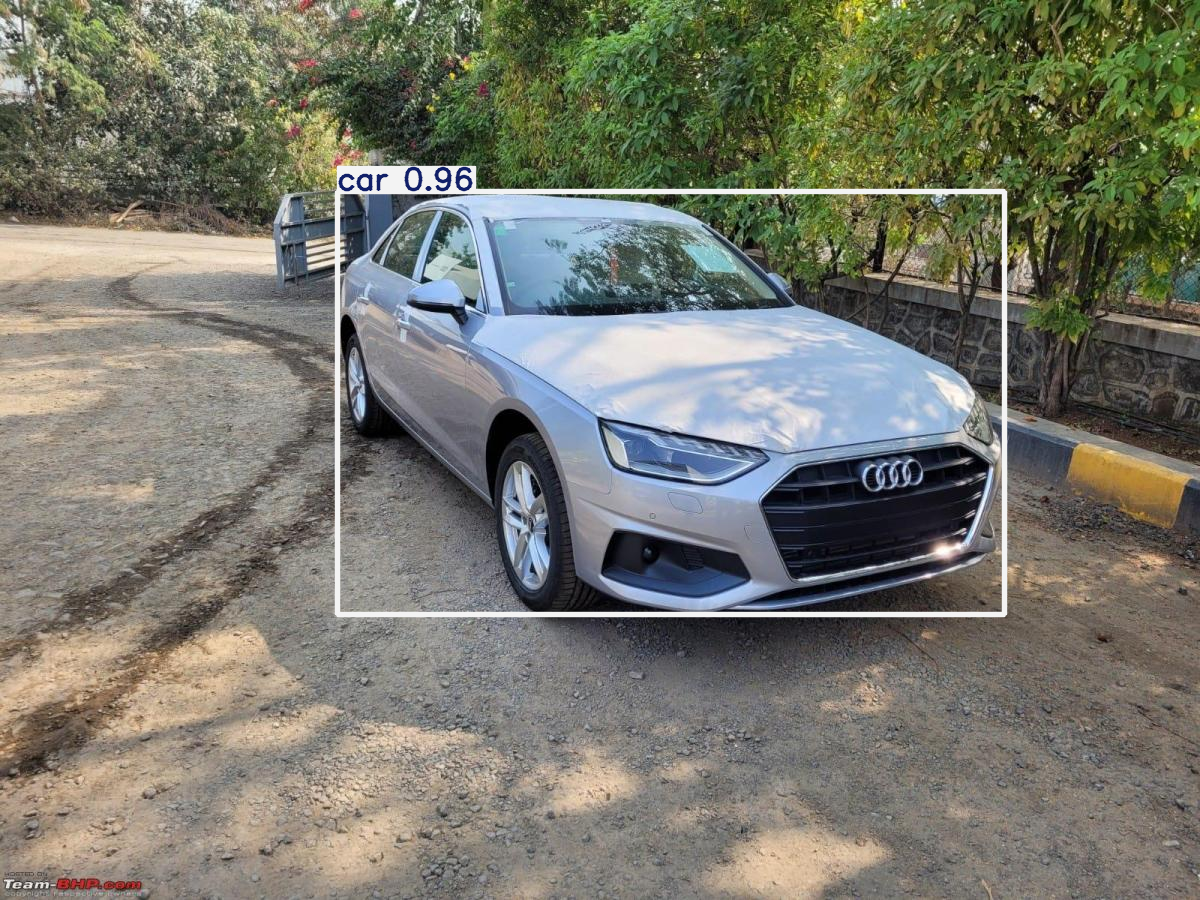

In [15]:
from google.colab.patches import cv2_imshow
# Predict bounding boxes
results = model.predict(image, classes=[2.0])  # Specify the class you want
boxes = results[0].boxes.xyxy.tolist()
cv2_imshow(results[0].plot())
# Enable PyTorch mixed precision for compatible GPUs
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()
if torch.cuda.is_available() and torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

# **Define Visualization Functions**

In [7]:
def show_mask(mask, ax, random_color=False, borders=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()


In [11]:
!wget -P /content/sam2/checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt


--2024-11-16 09:56:23--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.51, 3.163.189.14, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 898083611 (856M) [application/vnd.snesdev-page-table]
Saving to: ‘/content/sam2/checkpoints/sam2.1_hiera_large.pt’

sam2.1_hiera_large. 100%[===================>] 856.48M   156MB/s    in 4.4s    

2024-11-16 09:56:28 (193 MB/s) - ‘/content/sam2/checkpoints/sam2.1_hiera_large.pt’ saved [898083611/898083611]



# **Build the SAM2 Model**

In [12]:
sam2_checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

predictor = SAM2ImagePredictor(sam2_model)

# **Predict from YOLO and Visualize Masks via SAM2**

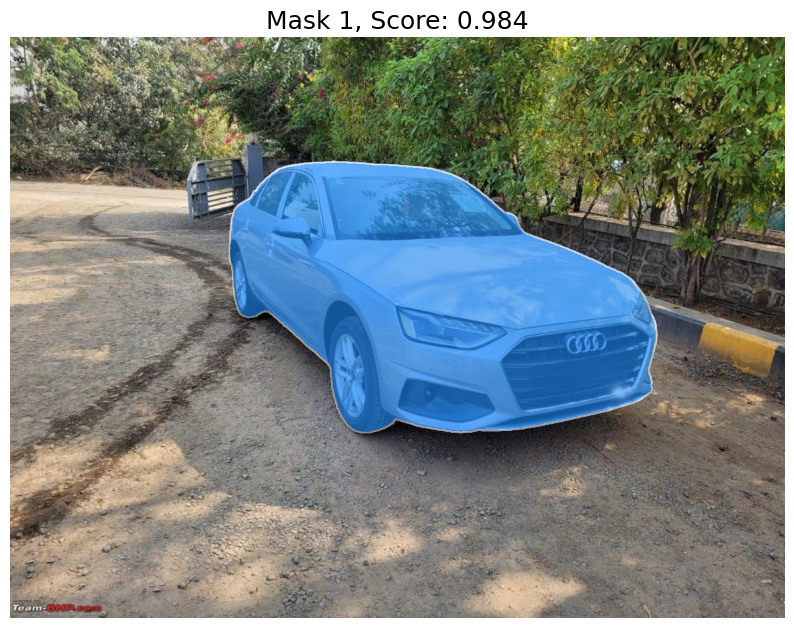

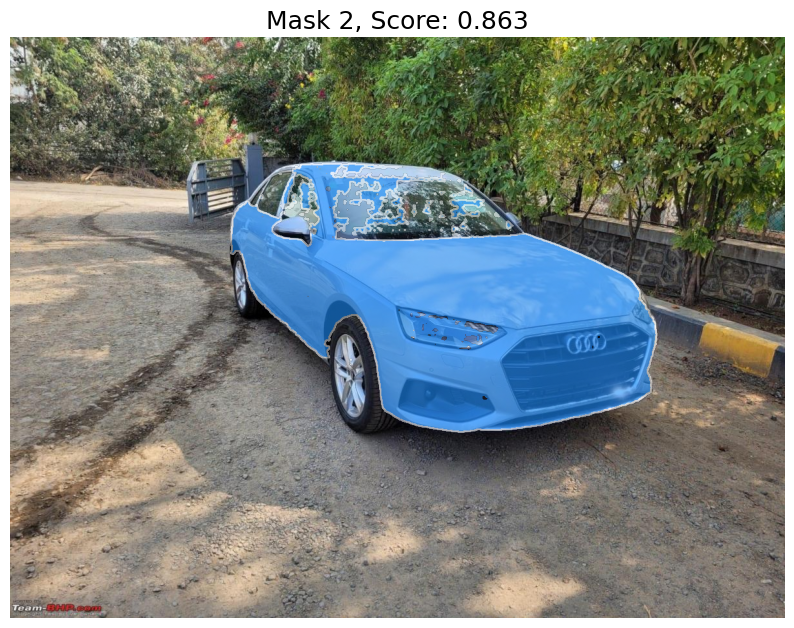

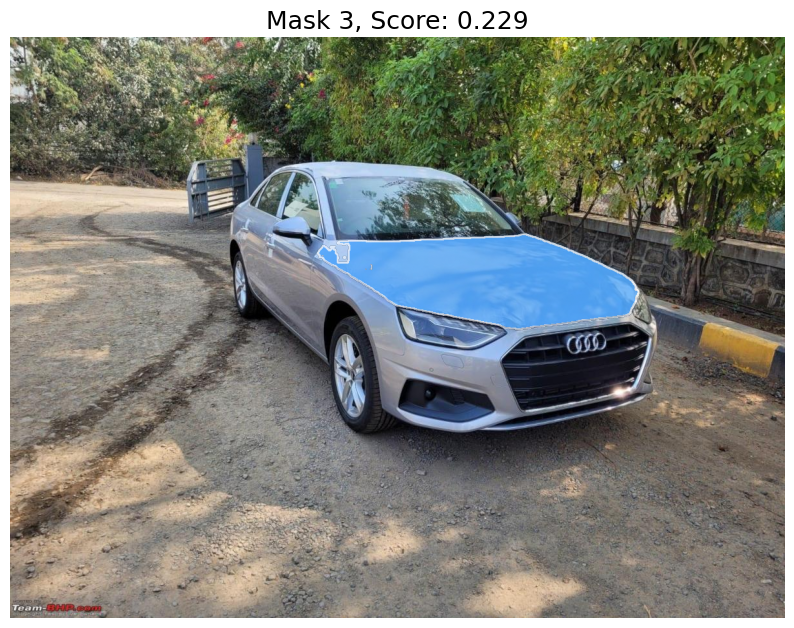

In [18]:
# Set the image for the predictor
predictor.set_image(image)

# Prepare bounding boxes and masks
input_boxes = []
for box in boxes:
    x1, y1, x2, y2 = box
    input_boxes.append(np.array([x1, y1, x2, y2]))

if len(input_boxes) > 1:
    masks, scores, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_boxes,
        multimask_output=False,
    )
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for mask in masks:
        show_mask(mask.squeeze(0), plt.gca(), random_color=True)
    for box in input_boxes:
        show_box(box, plt.gca())
    plt.axis('off')
    plt.show()
elif len(input_boxes) == 1:
    x1, y1, x2, y2 = input_boxes[0]
    input_box = np.array([x1, y1, x2, y2])
    xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
    input_point = np.array([[xm, ym]])
    input_label = np.array([1])
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label)
